In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Es 05
<b>Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.
<span style="color:red">Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.</b>

- <b> Use Bohr radius units, $a_0$ for distances
- <b> Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases
- <b> Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?
- <b> How large should be the number of Monte Carlo Metropolis steps in each block?
- <b> <span style="color:red">If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?</span>

#### Implementation of the Metropolis algorithm
My first step was to write a function that would implement the Metropolis algorithm in order to sample the wavefunction amplitudes.I made use of the class *RandomWalk* that I had built for exercise 3, that includes as private elements a random generator and the random walk position, and has methods to progressively get the random walk position and distance from the origin(norm of the position vector). I added a step function that increments each of the components by a randomly determined fraction of the input step length, so that I am actively generating a step in a random direction with a length between 0 and step_length. Then in the main file I created a *Metropolis_step()* function, that uses this method to increment the RW, and then generates a new random number, checks if it lower than the Metropolis acceptance, and if not reverts the RW to its old position:

**RandomWalk.cpp:**
```c++
void RandomWalk::Step_unif (){

for (int i=0;i<3;i++){
	double step = _steplength*_rnd.Rannyu(-1.,1.);
 	_position[i] += step;
}
}
```
**main.cpp:**
``` c++
double Metropolis_Acceptance(double p_new,double p_old,double T_fwd, double T_bkw){ //y:old move, x:new move
	double q = (T_fwd*p_new)/(T_bkw* p_old);
	if (q>=1.) return 1.;
	else return q;
}


void Metropolis_Step(Random &rnd,RandomWalk &RW, double &acc_rate){

		vec old_pos = RW.Get_position();
		double r_old = RW.GetDistance();

		RW.Step_unif();
		double r_new = RW.GetDistance();
		
		double a_0=1;

		double p_old = H_1s(a_0,r_old);
		double p_new = H_1s(a_0,r_new);
		double T_bkw=1.;
		double T_fwd =1.;

		double A=Metropolis_Acceptance(p_new,p_old,T_fwd,T_bkw);

		double x=rnd.Rannyu();

		if(x>A) {
			RW.SetPosition(old_pos);
		}

		else acc_rate ++;
}

To check if the algorithm is working, we can visualize the distribution points for only one random walk with 100000 steps, starting from $\vec{r}=(20,20,20)$:

In [25]:
file = "1s.csv"
df=pd.read_csv(file, sep='\t')
filep = '2p.csv'
dfp = pd.read_csv(filep,sep='\t')

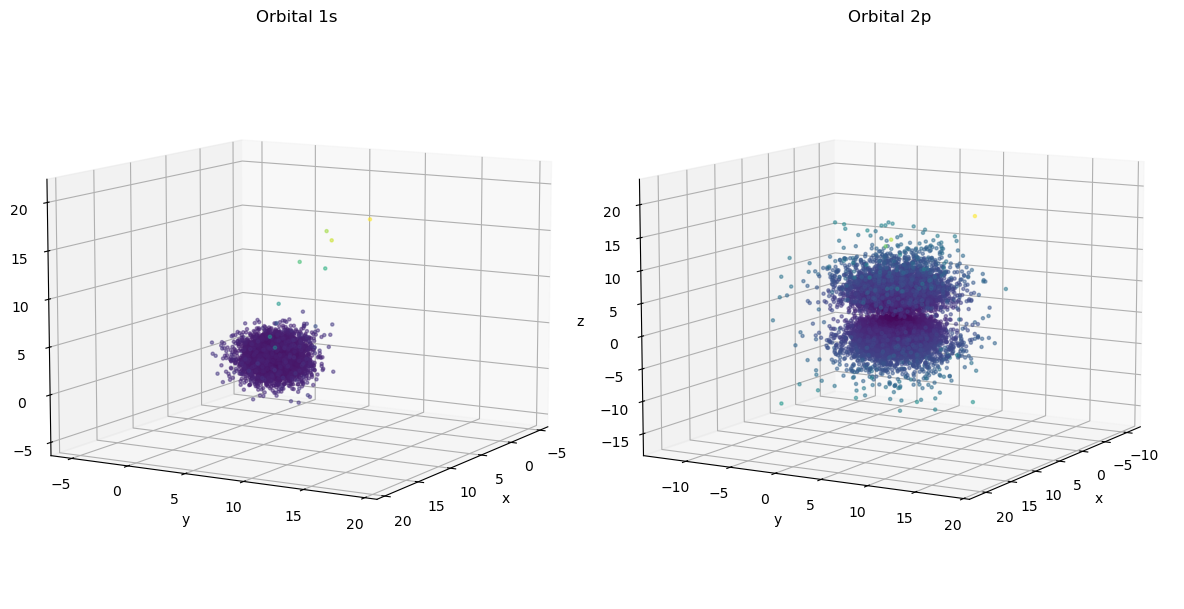

In [28]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
files = [df,dfp]

for i,data in enumerate(files):
    axes[i].scatter(
    data['x'][::10], data['y'][::10], data['z'][::10],
    c=data['r'][::10], alpha=0.5, marker='.'
)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_zlabel('z')
    axes[i].view_init(10,30)
axes[0].set_title('Orbital 1s')
axes[1].set_title('Orbital 2p')
plt.tight_layout()
plt.show()


**Determining optimal step length**: since the step length is directly connected to the acceptance rate of the Metropolis algorithm, I first tried to run only one block with for various values of the step length to determine which one would give me an acceptance of 50%.

In [44]:
file ="acceptance1s.csv"
df_acc = pd.read_csv(file,sep='\t')
df_accp = pd.read_csv('acceptance2p.csv',sep ='\t')
df_accp.head()

,step_length,acceptance
0,2.3,0.59189
1,2.4,0.57662
2,2.5,0.56256
3,2.6,0.55112
4,2.7,0.53637


Text(0.5, 1.0, 'Acceptance rate for 2p orbital')

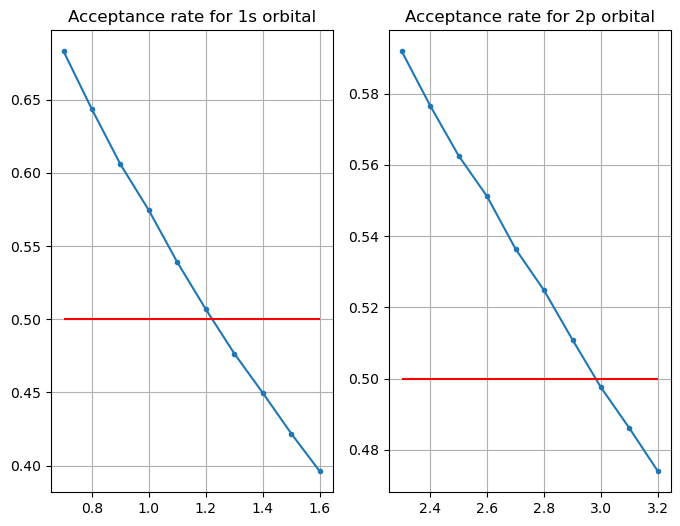

In [48]:
fig,axes = plt.subplots(1,2,figsize=(8,6))
files = [df_acc,df_accp]
for i,data in enumerate(files):
    axes[i].plot(data['step_length'],data['acceptance'], marker = '.')
    axes[i].hlines(0.5,data['step_length'][0],data['step_length'][9],color ='red')
    axes[i].grid()

axes[0].set_title('Acceptance rate for 1s orbital')
axes[1].set_title('Acceptance rate for 2p orbital')


Therefore, optimal values for the step length are **1.2** for the  1s and **2.9** for the 2p

In [46]:
print(f'1s acceptance rate with tep length 1.2: {df_acc['acceptance'][df_acc['step_length']==1.2]}')
print(f'2 pacceptance rate with tep length 2.9: {df_accp['acceptance'][df_accp['step_length']==2.9]}')

1s acceptance rate with tep length 1.2: 5    0.5068
Name: acceptance, dtype: float64
2 pacceptance rate with tep length 2.9: 6    0.51089
Name: acceptance, dtype: float64


In [32]:
file = "r_ave.csv"
dfr=pd.read_csv(file, sep='\t')
dfr.head()

,block,ave,prog_ave,err
0,0,3.4641,0.000035,0.010955
1,1,3.4641,0.000035,0.010955
2,2,3.4641,0.000035,0.010955
3,3,3.4641,0.000035,0.010955
4,4,3.4641,0.000035,0.010955


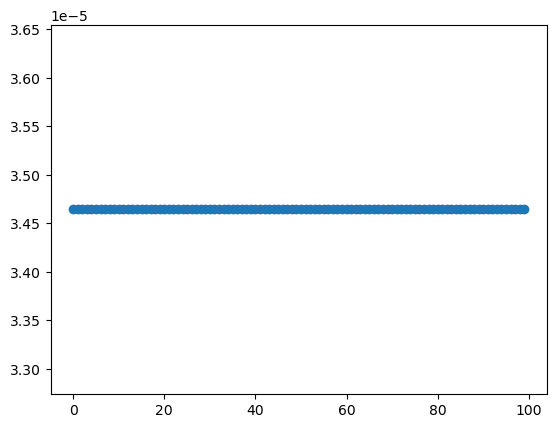

In [33]:
plt.scatter(dfr['block'],dfr['prog_ave'])

(array([1.190e+02, 5.400e+02, 1.160e+03, 2.525e+03, 3.954e+03, 5.206e+03,
        6.085e+03, 6.896e+03, 7.290e+03, 7.477e+03, 7.534e+03, 7.062e+03,
        6.448e+03, 5.731e+03, 5.350e+03, 4.479e+03, 3.859e+03, 3.534e+03,
        2.833e+03, 2.358e+03, 1.920e+03, 1.556e+03, 1.301e+03, 1.027e+03,
        8.810e+02, 6.630e+02, 5.160e+02, 4.110e+02, 2.860e+02, 2.090e+02,
        1.650e+02, 1.000e+02, 1.110e+02, 6.200e+01, 9.900e+01, 6.600e+01,
        3.800e+01, 4.600e+01, 2.100e+01, 2.100e+01, 8.000e+00, 1.300e+01,
        1.200e+01, 8.000e+00, 9.000e+00, 0.000e+00, 3.000e+00, 6.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0.368148  ,  0.75471304,  1.14127808,  1.52784312,  1.91440816,
         2.3009732 ,  2.68753824,  3.07410328,  3.46066832,  3.84723336,
         4.2337984 ,  4.62036344,  5.00692848,  5.39349352,  5.78005856,
         6.1666236 ,  6.55318864,  6.93975368,  7.32631872,  7.71288376,
         8.0994488 ,  8.48601384,  8.87257888,  9.25914392,  9.64570896,
        10.

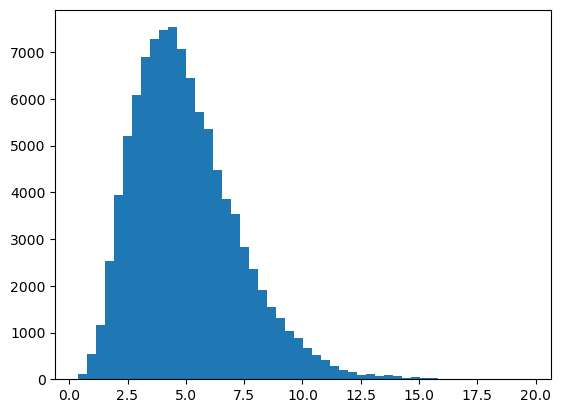

In [16]:
fig = plt.figure()
plt.hist(df['r'],bins=50)

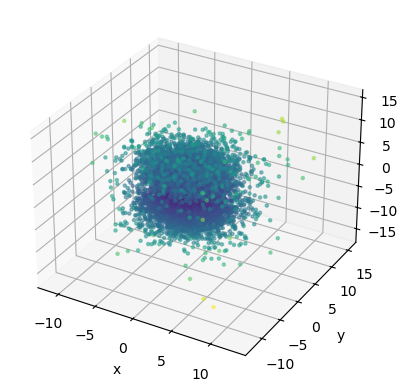

In [15]:
ax,fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['x'][::10],df['y'][::10],df['z'][::10], c=df['r'][::10],alpha=0.5, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


plt.show()

/tmp/ipykernel_21935/312616157.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


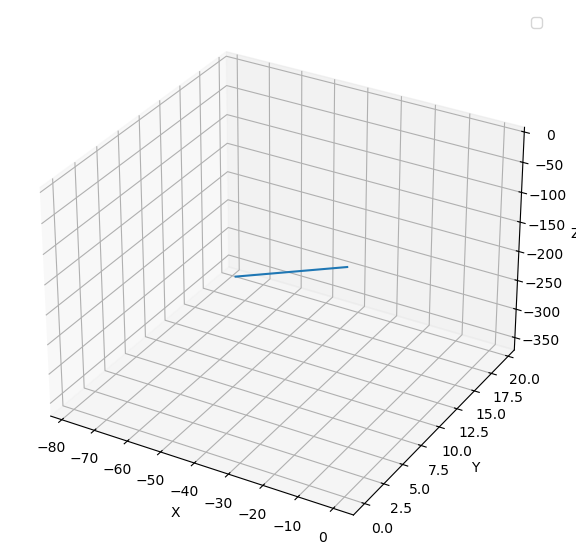

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# Colori distinti per ogni random walk

ax.plot(df['x'], df['y'], df['z'])

# Etichette e legenda
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.legend()

plt.show()


In [1]:
elisa = range(1, 1000)

print(elisa)


NameError: name 'elisa' is not defined